In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from functools import reduce
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import plotly.express as px
import plotly.graph_objects as go
import datetime
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings(action='once')

/home/huda/.local/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
#ETL-> extract, Transform & Load Pipeline 
# This function will read the input dataframe and perform some necessary functions:
# 1. Dropping rows with null values
# 2. Converting dates/times column to date_time format under column name "Date"
# 3. Remove the percentage symbols from the values of column(like Change% etc.) to make if float[for calculations]

def etl(df):
    for i in df.columns: # iterating over columns of input dataframe
        if df[i].isna().sum() == df.shape[0]: #if all the values of certain column in null, drop that
            df.drop(i,axis=1,inplace=True)
            continue
        if i=="Time": # if column with name "Time" is found, convert its values to date_time format
            df["Date"] = pd.to_datetime(df[i])
            df.drop("Time",axis=1,inplace=True)
        elif i=="Date": # if column with name "Date" is found, convert its values to date_time format
            df[i] = pd.to_datetime(df[i])
        elif df[i].dtype == "object": # if some column is found with datatype other than float/int etc.
            #convert its values to str
            df[i] = df[i].astype(str)
            df[i] = df[i].apply(lambda x:re.sub('[%]',"",x))
            df[i] = df[i].astype(float)
    return df

In [3]:
data = etl(pd.read_csv("df_all_predictors.csv"))

In [4]:
data.head(2)

,Date,SPY Open,SPY High,SPY Low,SPY Last,SPY Change,SPY %Chg,SPY Volume,SPY RSI,SPY_o Imp Vol,...,DXY Change,DXY %Chg,DXY Volume,CMBO Open,CMBO High,CMBO Low,CMBO Last,CMBO Change,CMBO %Chg,CMBO Volume
0,2018-10-03,292.74,293.21,291.32,291.72,0.16,0.05,64694500.0,54.634025,8.69,...,0.59,0.62,0.0,1980.64,1980.64,1980.64,1980.64,1.37,0.07,0.0
1,2018-10-04,291.18,291.24,287.66,289.44,-2.28,-0.78,111545904.0,54.634025,10.07,...,-0.32,-0.33,0.0,1967.24,1967.24,1967.24,1967.24,-13.40,-0.68,0.0


In [4]:
data.head(2)

,Date,SPY Open,SPY High,SPY Low,SPY Last,SPY Change,SPY %Chg,SPY Volume,SPY RSI,SPY_o Imp Vol,...,DXY Change,DXY %Chg,DXY Volume,CMBO Open,CMBO High,CMBO Low,CMBO Last,CMBO Change,CMBO %Chg,CMBO Volume
0,2018-10-03,292.74,293.21,291.32,291.72,0.16,0.05,64694500.0,54.634025,8.69,...,0.59,0.62,0.0,1980.64,1980.64,1980.64,1980.64,1.37,0.07,0.0
1,2018-10-04,291.18,291.24,287.66,289.44,-2.28,-0.78,111545904.0,54.634025,10.07,...,-0.32,-0.33,0.0,1967.24,1967.24,1967.24,1967.24,-13.40,-0.68,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1097 non-null   datetime64[ns]
 1   SPY Open            1097 non-null   float64       
 2   SPY High            1097 non-null   float64       
 3   SPY Low             1097 non-null   float64       
 4   SPY Last            1097 non-null   float64       
 5   SPY Change          1097 non-null   float64       
 6   SPY %Chg            1097 non-null   float64       
 7   SPY Volume          1097 non-null   float64       
 8   SPY RSI             1097 non-null   float64       
 9   SPY_o Imp Vol       1097 non-null   float64       
 10  SPY_o 1D IV Chg     1097 non-null   float64       
 11  SPY_o IV Rank       1097 non-null   float64       
 12  SPY_o IV Pctl       1097 non-null   float64       
 13  SPY_o Put/Call Vol  1097 non-null   float64     

In [6]:
data["Target"] = data["SPY Last"].shift(-1)

In [7]:
data.sort_values(by="Date",inplace=True)

In [8]:
data.dropna(inplace=True)

In [9]:
df = data.drop(["Date"],axis=1)

In [10]:
df.head(2)

,SPY Open,SPY High,SPY Low,SPY Last,SPY Change,SPY %Chg,SPY Volume,SPY RSI,SPY_o Imp Vol,SPY_o 1D IV Chg,...,DXY %Chg,DXY Volume,CMBO Open,CMBO High,CMBO Low,CMBO Last,CMBO Change,CMBO %Chg,CMBO Volume,Target
0,292.74,293.21,291.32,291.72,0.16,0.05,64694500.0,54.634025,8.69,-0.45,...,0.62,0.0,1980.64,1980.64,1980.64,1980.64,1.37,0.07,0.0,289.44
1,291.18,291.24,287.66,289.44,-2.28,-0.78,111545904.0,54.634025,10.07,1.38,...,-0.33,0.0,1967.24,1967.24,1967.24,1967.24,-13.40,-0.68,0.0,287.82


# FEATURE SELECTION

In [11]:
# target datafarem containing target labels
Y = df[["Target"]]

# possible feature space
X = df.drop(Y.columns,axis=1)

In [12]:
scalerX = MinMaxScaler()
X = scalerX.fit_transform(X)

scalerY = MinMaxScaler()
Y = scalerY.fit_transform(Y)

In [13]:
Y

array([[0.26099074],
       [0.25463181],
       [0.25463181],
       ...,
       [0.73677186],
       [0.72279793],
       [0.72652693]])

In [14]:
scalerY.inverse_transform(Y)

array([[289.44],
       [287.82],
       [287.82],
       ...,
       [410.65],
       [407.09],
       [408.04]])

In [15]:
feature_names = df.drop(["Target"],axis=1).columns.values

In [20]:
def get_rfe_results(n_features):
    reg = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate = 0.05, 
                     max_depth= 7, min_child_weight = 4, 
                     n_estimators = 100, nthread = 4, 
                     objective = 'reg:squarederror',
                     subsample = 0.7)

    # create the RFE model
    rfe = RFE(reg,n_features_to_select=n_features)
    rfe.fit(X, Y)
    
    selected_features = [feature for feature, rank in zip(list(feature_names), rfe.ranking_) if rank==1]

    return selected_features

In [21]:
def get_xgb_results(selected_features):
    features = df[selected_features]
    target = df[["Target"]]
    X_train,X_test,y_train,y_test = train_test_split(features,target,train_size=0.8,shuffle=False)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    pred_scaler = MinMaxScaler()
    y_train = pred_scaler.fit_transform(y_train)
    y_test = pred_scaler.transform(y_test)
    
    model = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate = 0.05, 
                     max_depth= 7, min_child_weight = 4, 
                     n_estimators = 100, nthread = 4, 
                     objective = 'reg:squarederror',
                     subsample = 0.7)
    
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test,preds)
    mse = mean_squared_error(y_test,preds)
    return (mae,mse)

In [22]:
results = []
for i in range(1,60):
    print("Testing with n_features_to_select = ",i)
    selected_features = get_rfe_results(i)
    mae,mse = get_xgb_results(selected_features)
    print("Mean Absolute Error = {:.4f}".format(mae))
    print("\t---------------")
    results.append({"n_features":i , "mae":mae , "mse":mse})

Testing with n_features_to_select =  1
Mean Absolute Error = 0.0233
	---------------
Testing with n_features_to_select =  2
Mean Absolute Error = 0.0220
	---------------
Testing with n_features_to_select =  3
Mean Absolute Error = 0.0234
	---------------
Testing with n_features_to_select =  4
Mean Absolute Error = 0.0223
	---------------
Testing with n_features_to_select =  5
Mean Absolute Error = 0.0245
	---------------
Testing with n_features_to_select =  6
Mean Absolute Error = 0.0252
	---------------
Testing with n_features_to_select =  7
Mean Absolute Error = 0.0249
	---------------
Testing with n_features_to_select =  8
Mean Absolute Error = 0.0255
	---------------
Testing with n_features_to_select =  9
Mean Absolute Error = 0.0264
	---------------
Testing with n_features_to_select =  10
Mean Absolute Error = 0.0278
	---------------
Testing with n_features_to_select =  11
Mean Absolute Error = 0.0287
	---------------
Testing with n_features_to_select =  12
Mean Absolute Error = 0

In [26]:
result_data = pd.DataFrame(results)

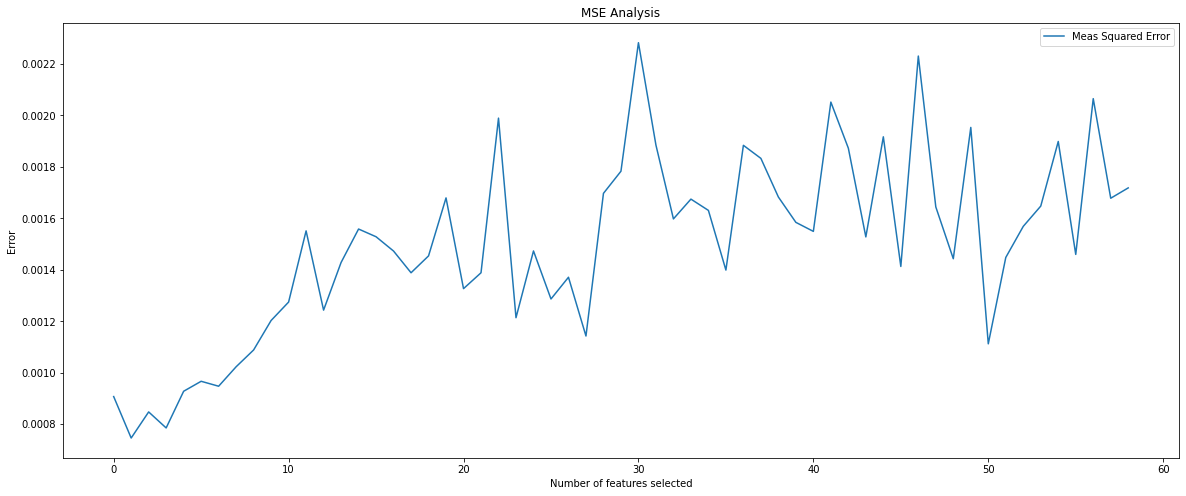

In [35]:
plt.figure(figsize=(20,8))
plt.plot(result_data.mse,label = "Meas Squared Error")
plt.xlabel("Number of features selected")
plt.ylabel("Error")
plt.title("MAE Analysis")
plt.legend()

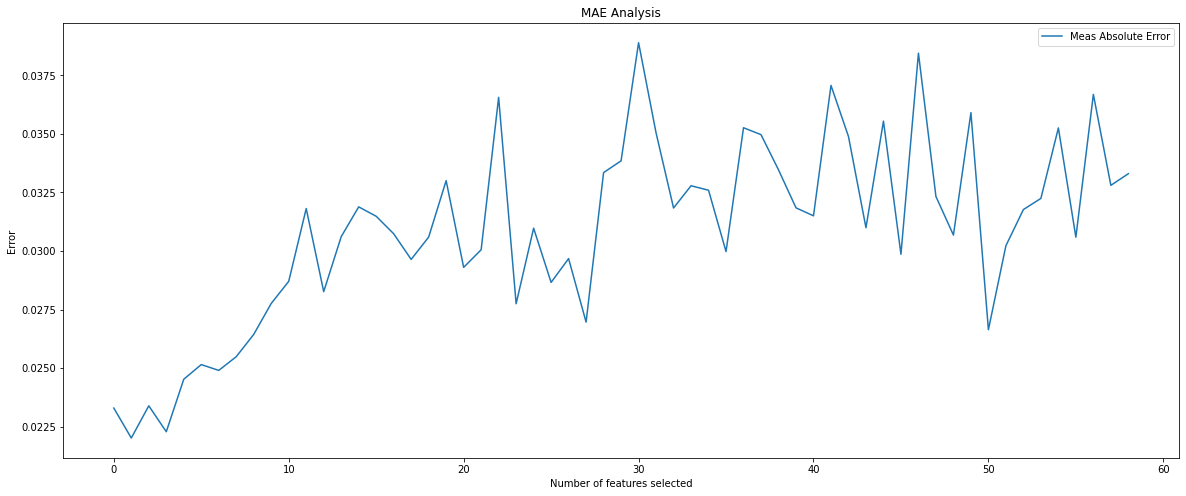

In [34]:
plt.figure(figsize=(20,8))
plt.plot(result_data.mae,label = "Meas Absolute Error")
# plt.plot(result_data.mse,label = "Meas Squared Error")
plt.xlabel("Number of features selected")
plt.ylabel("Error")
plt.title("MAE Analysis")
plt.legend()

In [27]:
# result_data.to_csv("n_features_comparison.csv")

In [24]:
features = df[selected_features]
target = df[["Target"]]

# PRE-PROCESSING

In [25]:
X_train,X_test,y_train,y_test = train_test_split(features,target,train_size=0.8,shuffle=False)

In [26]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pred_scaler = MinMaxScaler()
y_train = pred_scaler.fit_transform(y_train)
y_test = pred_scaler.transform(y_test)

In [27]:
df[["Target"]].iloc[0][0] , pred_scaler.inverse_transform(y_train)[0][0]

(289.44, 289.44)

# PREDCTION

In [28]:
model = XGBRegressor(colsample_bytree = 0.7, 
                     learning_rate = 0.05, 
                     max_depth= 7, min_child_weight = 4, 
                     n_estimators = 100, nthread = 4, 
                     objective = 'reg:linear',
                     subsample = 0.7)

In [29]:
model.fit(X_train,y_train)

[00:56:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

In [30]:
preds = model.predict(X_test)

In [31]:
print("Mean absolute Error = {:.4f}".format(mean_absolute_error(y_test,preds)))
print("Mean squared Error = {:.4f}".format(mean_squared_error(y_test,preds)))

Mean absolute Error = 0.0282
Mean squared Error = 0.0013


In [49]:
INPUT_FEATURES_VALUES = features #feature value from actual data frame
ACTUAL_TARGET_VALUES = target.values #target column from actual data
scaled_input = scaler.transform(INPUT_FEATURES_VALUES) #scaling features to feed model to get results

# FETTING MODEL'S PREDICTION OVER FEATURES FROM DATA
PREDICTED_MODEL_OUTPUT = model.predict(scaled_input)

In [53]:
PREDICTED_MODEL_OUTPUT = pred_scaler.inverse_transform(PREDICTED_MODEL_OUTPUT.reshape(-1,1))

In [85]:
resultant_dataframe = pd.DataFrame({'ACTUAL_TARGET_VALUES':ACTUAL_TARGET_VALUES.ravel(), 
                                    'PREDICTED_MODEL_OUTPUT':PREDICTED_MODEL_OUTPUT.ravel()})

In [86]:
resultant_dataframe.insert(1, "residuals",
                           resultant_dataframe["PREDICTED_MODEL_OUTPUT"] - resultant_dataframe["ACTUAL_TARGET_VALUES"],
                           True)

In [87]:
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in resultant_dataframe["residuals"].dropna()]

In [88]:
resultant_dataframe.index = data.Date

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = resultant_dataframe["ACTUAL_TARGET_VALUES"] , x = resultant_dataframe.index,
                      name = "ACTUAL" , mode="lines"))
fig.add_trace(go.Scatter(y = resultant_dataframe["PREDICTED_MODEL_OUTPUT"] , x = resultant_dataframe.index,
                     name = "PREDICTED",mode = "lines"))
fig.add_trace(
    go.Bar(y = resultant_dataframe["residuals"].dropna() ,  x = resultant_dataframe.index,
           marker = {'color' : df_sub}, name = "Difference")
)
fig.update_layout(
        xaxis = dict(rangeslider=dict(
            visible=True
        ),
        type="date"),
        hovermode="x unified" , width = 1000,
        legend_title= "TRACES",
        yaxis_title= "VALUE OF TARGET LAST" ,xaxis_title="TIME",
        hoverlabel = dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )
fig.show()

/home/huda/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# HUNT FOR BEST PARAMETERS FOR THE REGRESSOR

In [26]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,100,50]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
xgb_grid.fit(MinMaxScaler().fit_transform(features),MinMaxScaler().fit_transform(target))

In [ ]:
print(xgb_grid.best_params_)

In [ ]:
print(abs(xgb_grid.best_score_))